# INCLUDE
Instruction to colab user:
- Run the first cell to install auto-sklearn on colab, and auto restart runtime, then proceed to run the following cells
- Run the second cell to mount google drive for I/O of dataset, results. In this notebook, dataset can be load from pickle and results can be dump to pickle.

Instruction to non-colab user:
- Ignore first two cell
- Change the paths


## Run for colab

In [ ]:
# For Colab, you need to install auto-sklearn every time
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install auto-sklearn # Downgrade scipy to 1.4.x
    #!pip install scipy # Upgrade scipy to 1.7.x

import os, signal
os.kill(os.getpid(), signal.SIGKILL) # Restart_runtime

     |████████████████████████████████| 6.3 MB 1.1 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 22.3 MB 1.1 MB/s 
     |████████████████████████████████| 722 kB 55.2 MB/s 
     |████████████████████████████████| 4.2 MB 15.8 MB/s 
     |████████████████████████████████| 4.0 MB 46.8 MB/s 
     |████████████████████████████████| 208 kB 58.9 MB/s 
     |████████████████████████████████| 973 kB 49.9 MB/s 
     |████████████████████████████████| 132 kB 46.5 MB/s 
     |████████████████████████████████| 45 kB 2.7 MB/s 
  Created wheel for auto-sklearn: filename=auto_sklearn-0.14.2-py3-none-any.whl size=6586738 sha256=431ef552cdf26d71a1ea99ba66415fe184ed9bd18be168b45b686ea0ebb6d238
  Stored in directory: /root/.cache/pip/wheels/b6/ba/aa/ce7b8deb41019b9c1c6cd0b511d553350b7075ba1d3f0f545c
  Created wheel for pynisher: filename=pynisher-0.6.4-py3-none-any.whl size=7044 sha256=9276353773e0413688d727c96952507ef32bb27d84d7ec746e5b4520d1ac4b8

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Run for everyone

In [ ]:
# Dependencies
# Common
import os
import pickle
import sys
import time
from tqdm.autonotebook import tqdm
from datetime import datetime

import numpy as np
import pandas as pd

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# ML
import sklearn # Import sklearn before autosklearn, solve scipy version error
from sklearn.model_selection import train_test_split
import sklearn.datasets
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# AML
import autosklearn
import autosklearn.classification
from autosklearn.metrics import balanced_accuracy, precision, recall

# Wilcoxon test
from scipy.stats import wilcoxon

# Check machine
#import multiprocessing
#multiprocessing.cpu_count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


## Set paths

In [ ]:
# Set up paths

# User insert folder to store pickles
# dataset name in format openml_xxx.pkl
datasets_folder = '/content/drive/My Drive/Colab Notebooks/course_AML_proj/data'
results_folder = '/content/drive/My Drive/Colab Notebooks/course_AML_proj/results'

In [ ]:
# Look up results directory
os.listdir(results_folder)

['experiment_20211202-220329.pkl',
 'openml_meta_features.pkl',
 'experiment_20211203-081432.pkl']

# Functions

In [ ]:
def Load_result_pkl(folder_path, result_name):
    fname = os.path.join(folder_path, result_name)
    file_read = open(fname, "rb")
    res = pickle.load(file_read) # Load pickle to data
    file_read.close()
    return res

def Prep_res_df(res, meta_features_df):
    res_df = pd.DataFrame({k:{'mean_acc': np.mean(v['acc']), 'sd_acc': np.std(v['acc'])} for k,v in res.items()}).T
    res_df.reset_index(inplace=True)
    res_df.rename(columns={'index': 'dataset'}, inplace=True)
    res_df = res_df.merge(
        meta_features_df, 
        how='inner', on='dataset')
    return res_df

In [ ]:
def Compare_acc_meta_feature(res_df, y1, y2):
    # Plot test acc avg on each dataset
    fig, ax1 = plt.subplots(figsize=(20,4))
    ax2 = ax1.twinx()

    sns.scatterplot(x='dataset', y=y1, 
                    data=res_df.sort_values('mean_acc'),
                    color='r',
                    ax=ax1)
    sns.scatterplot(x='dataset', y=y2, 
                    data=res_df.sort_values('mean_acc'), 
                    color='b',
                    ax=ax2)

    ax2.set(yscale='log')

    ax1.tick_params(axis='x', rotation=90)
    ax1.set_xlabel('Dataset')
    ax1.set_ylabel('Balanced accuracy')
    ax2.set_ylabel(y2)

    ax1.grid(color='k', linestyle='--', alpha=0.2, linewidth=1)

    fig.legend([y1, y2],
            loc='lower right')

    fig.tight_layout()

    return fig

def Scatter_acc_meta_feature(res_df):
    x, y, z = res_df['n_instance'], res_df['n_feature'], res_df['mean_acc']

    fig, ax = plt.subplots()

    plt.scatter(x=x, y=y, c=z,
                cmap='inferno')

    ax.set(xscale='log', yscale='log')

    ax.set_xlabel('n_instance')
    ax.set_ylabel('n_feature')
    ax.set_facecolor('silver')

    plt.colorbar(ax=ax)

    plt.tight_layout()

    return fig

# Load meta features

In [ ]:
folder_path = results_folder

fname = os.path.join(folder_path, 'openml_meta_features.pkl')
file_read = open(fname, "rb")
meta_features = pickle.load(file_read) # Load pickle to data
file_read.close()

In [ ]:
meta_features_df = pd.DataFrame(meta_features).T
meta_features_df.reset_index(inplace=True)
meta_features_df.rename(columns={'index': 'dataset'}, inplace=True)
meta_features_df.head()

,dataset,n_instance,n_feature,n_class
0,41168,83733,54,4
1,1596,581012,54,7
2,41150,130064,50,2
3,40668,67557,42,3
4,3,3196,36,2


# Experiment 1 part 1

## Process results

In [ ]:
load_result = 'experiment_20211202-220329.pkl'
res1 = Load_result_pkl(results_folder, load_result)
res1_df = Prep_res_df(res1, meta_features_df)

## Inspect results

In [ ]:
res_df = res1_df

In [ ]:
# Worst 5
res_df.sort_values('mean_acc').head()

,dataset,mean_acc,sd_acc,n_instance,n_feature,n_class
14,41167,0.002817,0.0,416188,60,355
21,41169,0.080339,0.0,65196,27,100
0,41165,0.100000,0.0,10000,7200,10
7,40996,0.100000,0.0,70000,784,10
32,40685,0.142857,0.0,58000,9,7


In [ ]:
# Best 5
res_df.sort_values('mean_acc').tail()

,dataset,mean_acc,sd_acc,n_instance,n_feature,n_class
5,1468,0.951517,0.010539,1080,856,9
9,12,0.979841,0.006431,2000,216,10
26,40984,0.981813,0.002698,2310,18,7
19,3,0.985300,0.001506,3196,36,2
34,40975,0.985431,0.006899,1728,6,4


In [ ]:
# Test on subset first
np.array(res_df.sort_values('mean_acc').tail(10)['dataset'])

array(['41143', '54', '1489', '40981', '41146', '1468', '12', '40984',
       '3', '40975'], dtype=object)

In [ ]:
res1['3']['cls'][1].leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
2,1,0.58,random_forest,0.012135,3.992263
9,2,0.06,lda,0.075517,2.200134
3,3,0.36,adaboost,0.109730,3.742078


## Figures

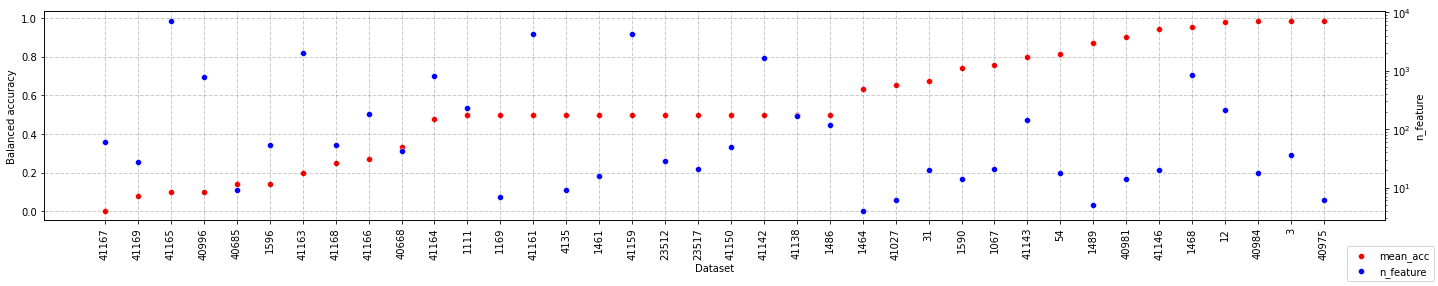

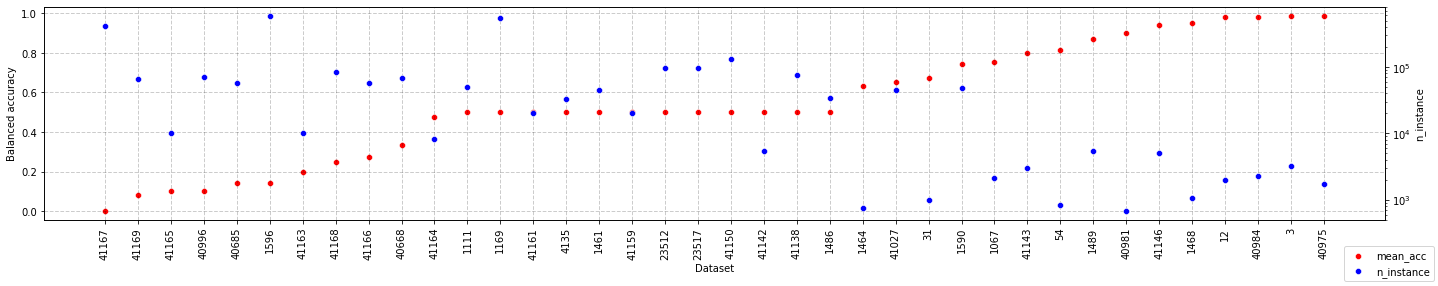

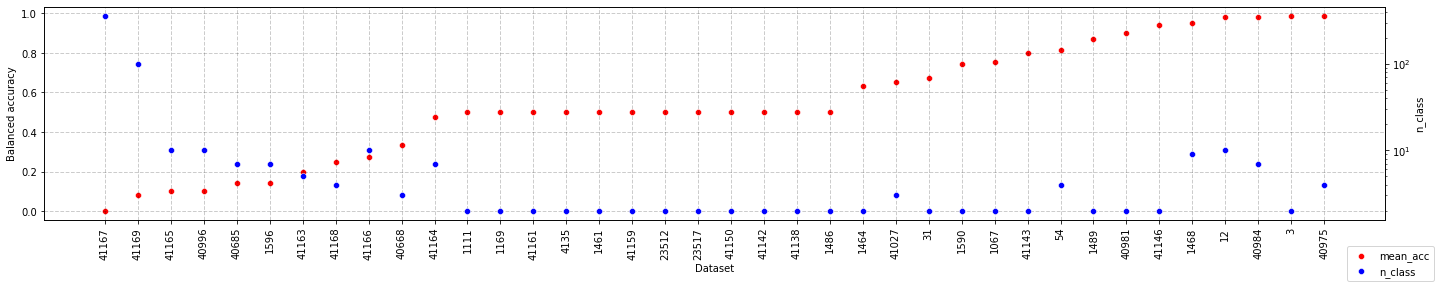

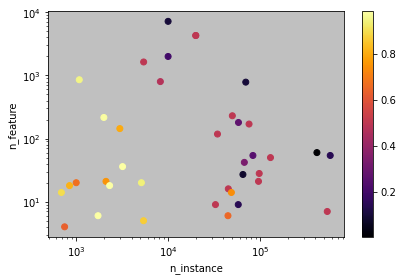

In [101]:
res_df = res1_df

y1, y2 = 'mean_acc', 'n_feature'
g1 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_instance'
g2 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_class'
g3 = Compare_acc_meta_feature(res_df, y1, y2)

g4 = Scatter_acc_meta_feature(res_df)

In [ ]:
# Not used

# Plot test acc distribution on each dataset
fig, ax = plt.subplots(figsize=(20,8))
sns.violinplot(x='dataset', y='mean_acc', 
               data=res_df.sort_values('mean_acc'), 
               ax=ax)

ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Dataset')
ax.set_ylabel('Balanced accuracy')

ax.grid(color='k', linestyle='--', alpha=0.2, linewidth=1)

fig.tight_layout()

fig_name = 'res_plot_' + fname + '.png'
#fig.savefig(fig_name)

# Experiment 1 part 2
increased time budget = 240s

## Process results

In [ ]:
load_result = 'experiment_20211203-081432.pkl'
res2 = Load_result_pkl(results_folder, load_result)
res2_df = Prep_res_df(res2, meta_features_df)

## Figures

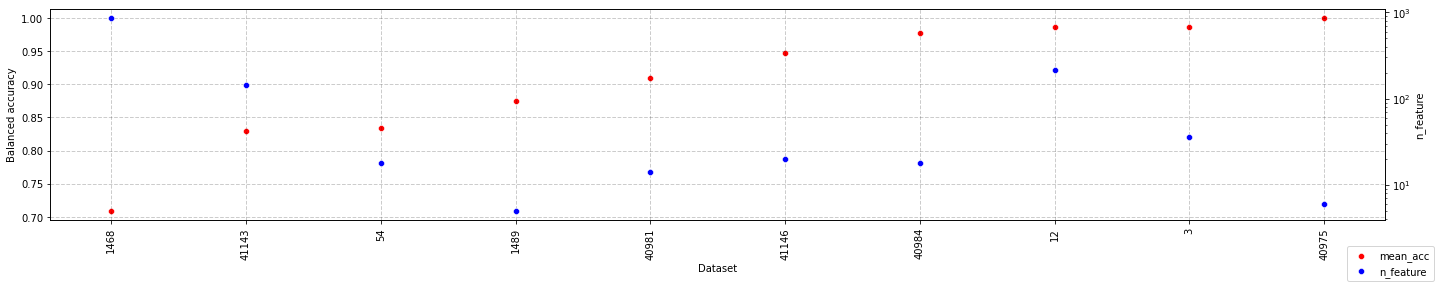

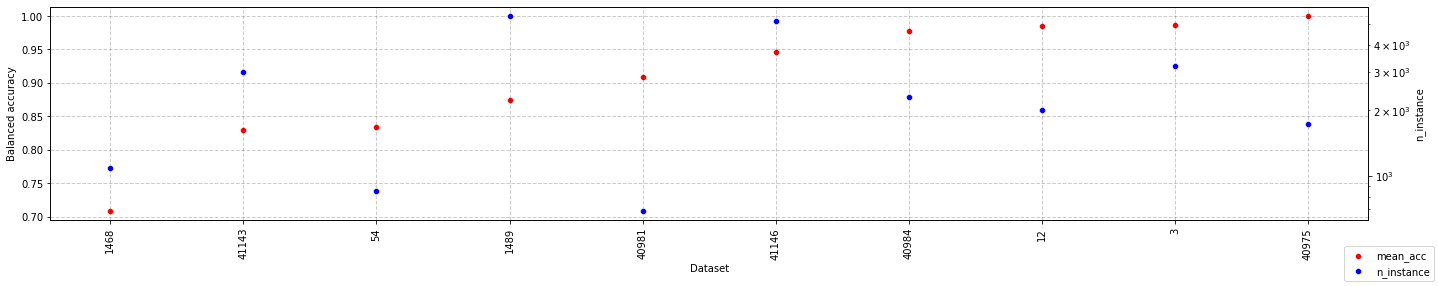

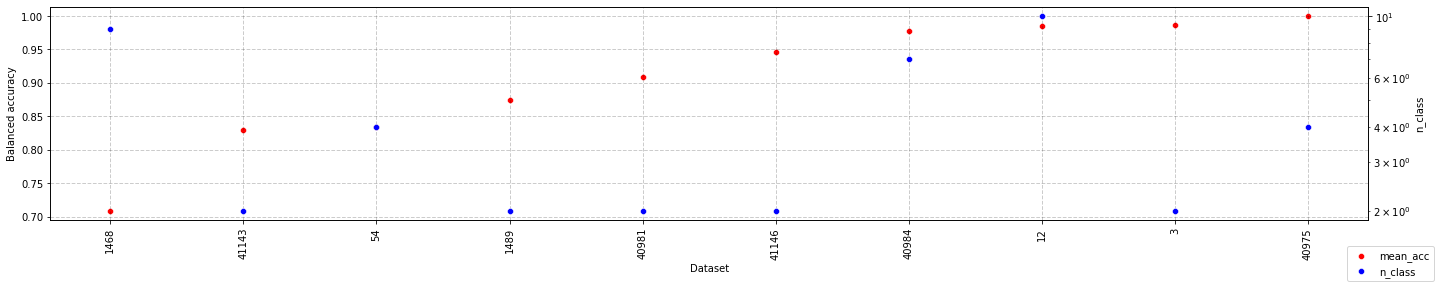

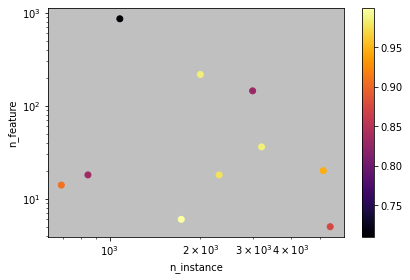

In [ ]:
res_df = res2_df

y1, y2 = 'mean_acc', 'n_feature'
g1 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_instance'
g2 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_class'
g3 = Compare_acc_meta_feature(res_df, y1, y2)

g4 = Scatter_acc_meta_feature(res_df)

# Wilcoxon signed-rank test
To test the null hypothesis that there is no difference between two set of values, we can apply the two-sided test.

In [ ]:
# Filter out results on same dataset in two differnt run
datasets_to_compare = np.intersect1d(res1_df['dataset'], res2_df['dataset'])
# Construct result table
compare_res_df = res1_df[['dataset', 'mean_acc', 'sd_acc']].merge(
    res2_df[['dataset', 'mean_acc', 'sd_acc']], 
    on='dataset', how='inner',
    suffixes=('_exp1', '_exp2'))
# Compute difference
compare_res_df['improvement'] = compare_res_df['mean_acc_exp2'] - compare_res_df['mean_acc_exp1']
# Compute p-values for Wilcoxon signed-rank test
pvals = {dataset: wilcoxon(res1[dataset]['acc'], 
                   res2[dataset]['acc'], 
                   alternative='two-sided')[1] for dataset in datasets_to_compare}
# Merge to result table
compare_res_df['pval_signedrank'] = compare_res_df['dataset'].map(pvals).fillna('')


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [ ]:
# Show result
compare_res_df

,dataset,mean_acc_exp1,sd_acc_exp1,mean_acc_exp2,sd_acc_exp2,improvement,pval_signedrank
0,1468,0.951517,0.010539,0.709182,0.301034,-0.242335,0.062500
1,12,0.979841,0.006431,0.985477,0.003484,0.005637,0.312500
2,41143,0.798071,0.002982,0.829970,0.002243,0.031899,0.062500
3,3,0.985300,0.001506,0.986602,0.001189,0.001302,0.108809
4,41146,0.943067,0.003071,0.946819,0.002472,0.003751,0.125000
5,40984,0.981813,0.002698,0.977665,0.001179,-0.004147,0.067889
6,54,0.813181,0.019257,0.834590,0.021481,0.021409,0.125000
7,40981,0.899937,0.005826,0.908641,0.005958,0.008704,0.062500
8,40975,0.985431,0.006899,0.999438,0.001124,0.014007,0.062500
9,1489,0.868555,0.018134,0.874925,0.003547,0.006370,0.812500
